In [ ]:
import s3fs
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as col

import nbconvert



In [2]:

# define CHPC pando S3 archive
fs = s3fs.S3FileSystem(anon=True,client_kwargs={'endpoint_url':"https://pando-rgw01.chpc.utah.edu/"})
#define paramemter
zarr_store = s3fs.S3Map(f"s3://hrrr-yearly-zarr/2024/2m_above_ground/TMP.zarr", s3=fs)
# dump to xarray
temperature= xr.open_zarr(zarr_store)

In [3]:
#show contents of temperature xarray
temperature

<xarray.Dataset>
Dimensions:                  (time: 8784, y: 1059, x: 1799)
Coordinates:
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
    forecast_reference_time  (time) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
    height                   (time) float64 dask.array<chunksize=(24,), meta=np.ndarray>
    latitude                 (y, x) float64 dask.array<chunksize=(150, 150), meta=np.ndarray>
    longitude                (y, x) float64 dask.array<chunksize=(150, 150), meta=np.ndarray>
    pressure                 (time) float64 dask.array<chunksize=(24,), meta=np.ndarray>
  * time                     (time) datetime64[ns] 2024-01-01 ... 2024-12-31T...
  * x                        (x) float64 -2.698e+06 -2.695e+06 ... 2.696e+06
  * y                        (y) float64 -1.587e+06 -1.584e+06 ... 1.587e+06
Data variables:
    TMP                      (time, y, x) float16 dask.array<chunksize=(24, 150, 150), meta=np.ndarray>

In [4]:
#kslc
zlat = 40.77069
zlon = -111.96503

In [5]:
# Define time range
start_date = "2024-07-01"
end_date = "2024-07-31"

# Compute Euclidean distance using latitude and longitude
distances = np.sqrt((temperature['longitude'] - zlon) ** 2 + (temperature['latitude'] - zlat) ** 2)

# Find the indices of the minimum distance
min_distance_idx = np.unravel_index(np.argmin(distances.values), distances.shape)

# Extract the nearest x and y indices correctly
nearest_y_idx, nearest_x_idx = min_distance_idx
nearest_x = temperature['x'].isel(x=nearest_x_idx)
nearest_y = temperature['y'].isel(y=nearest_y_idx)

# Select the temperature data for the nearest point within the time range
temperature_point = temperature["TMP"].sel(
    time=slice(start_date, end_date),
    x=nearest_x,
    y=nearest_y,
)

# Load the data into a DataFrame
temperature_p = temperature_point.load() - 273.16  # Convert from Kelvin to Celsius

# Create a DataFrame from xarray
df_temperature = pd.DataFrame({
    "time": temperature_p.time.values,
    "TEMP": temperature_p.values  # Extract values from xarray
})

# Set the time column as index
df_temperature.set_index("time", inplace=True)


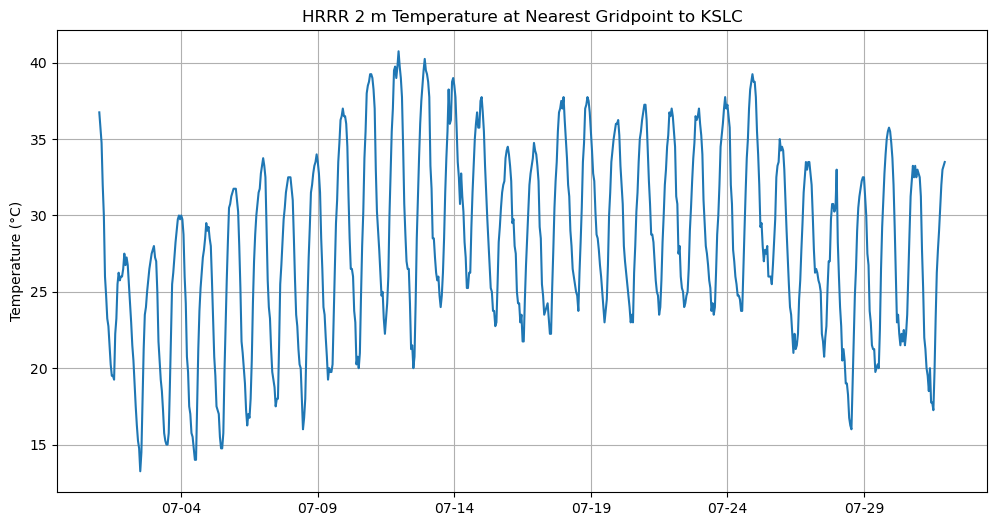

In [6]:

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df_temperature.TEMP, color="tab:blue")  # Ensure time is properly accessed
plt.title("HRRR 2 m Temperature at Nearest Gridpoint to KSLC")
# Format x-axis to display MM-DD-HH format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))  # Format dates as MM-DD
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Show labels every 2 days

plt.ylabel("Temperature (°C)")
plt.grid()
plt.show()


In [7]:
#area for plot
lon1 = -97.5
lat1 = 38.5
slat = 38.5

projData= ccrs.LambertConformal(central_longitude=lon1,
                             central_latitude=lat1,
                             standard_parallels=[slat])

   
latN = 47
latS = 31
lonW = -122
lonE = -107

#get grid coordinates
x = temperature['x']
y = temperature['y']

# Define the exact timestamp for selection
map_time = "2024-08-11T00:00:00"
selected_time = np.datetime64(map_time) 

# get temperature data for the given time
temperature_map = temperature["TMP"].sel(time=selected_time)-273.16


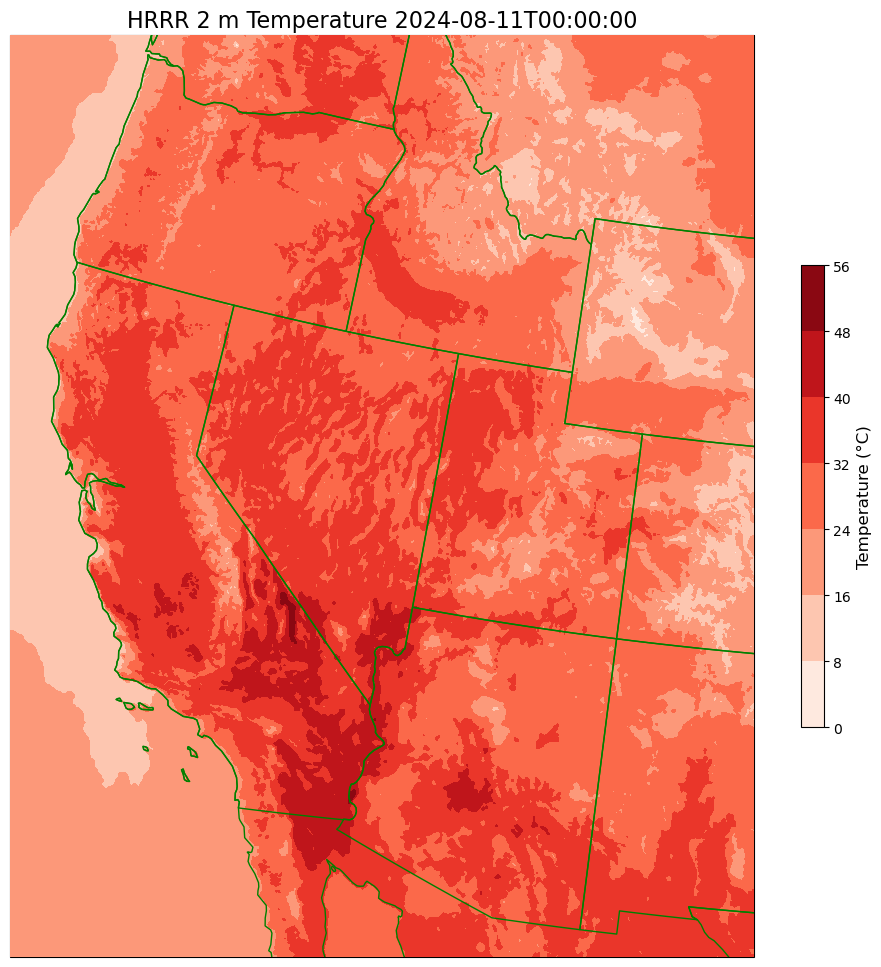

In [8]:
res = '50m'
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(1,1,1,projection=projData)
ax.set_extent ([lonW,lonE,latS,latN],crs=ccrs.PlateCarree())
# Add the title
tl1 = str('HRRR 2 m Temperature ')+ map_time
plt.title(tl1,fontsize=16)
ax.add_feature(cfeature.COASTLINE.with_scale(res),edgecolor='green',zorder=97)
ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='green',zorder=97)
# Contour fill
CF = ax.contourf(x,y,temperature_map.values,cmap='Reds',zorder=10)
cbar = fig.colorbar(CF,shrink=0.5)
cbar.set_label("Temperature (°C)", size='large')
plt.show()